## Deep Neural Network model: FAMD
*Summary:* In this notebook, we use DNN models to predict binary attack/normal labels as well as multi-class attack categories using Factorical Analysis of Mixed Data (FAMD).

In [2]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

train = pd.read_csv("../dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv("../dataset/UNSW_NB15_testing-set.csv")

df = pd.concat([train, test]).reset_index(drop=True)
df = df.drop(columns=["id"])
df

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,0,0,0.011000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.000300,254,0,8.810000e+08,0.000000,0,0,0.008000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.005100,254,0,8.544000e+08,0.000000,0,0,0.005000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,0,0,0.006000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.002500,254,0,8.504000e+08,0.000000,0,0,0.010000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,Generic,1
257669,0.505762,tcp,-,FIN,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.98057,3721.068786,120.177727,255,3518776216,3453092386,255,0.09944,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,Shellcode,1
257670,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,Generic,1
257671,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,Generic,1


In [3]:
labels = df['label']
mc_labels = df['attack_cat']
x_df = df.drop(columns=['label', 'attack_cat']).reset_index(drop=True)

### Preprocessing
First, we find how many components are required to explain 95% of the inertia in FAMD

In [4]:
cat_cols = x_df.select_dtypes(exclude=np.number).columns
num_cols = x_df.select_dtypes(include=np.number).columns

num_components = len(num_cols)
for cat in cat_cols:
    num_components += x_df[cat].nunique()

print(f"Number of components: {num_components}")

Number of components: 196


In [5]:
!pip install prince
from prince import FAMD

In [6]:
famd = FAMD(
    n_components=num_components,
    n_iter=5,
    random_state=42,
)
famd = famd.fit(x_df)

We plot the cumulative inertia against the number of components. This results in around 152 components that explain 95% of the variance

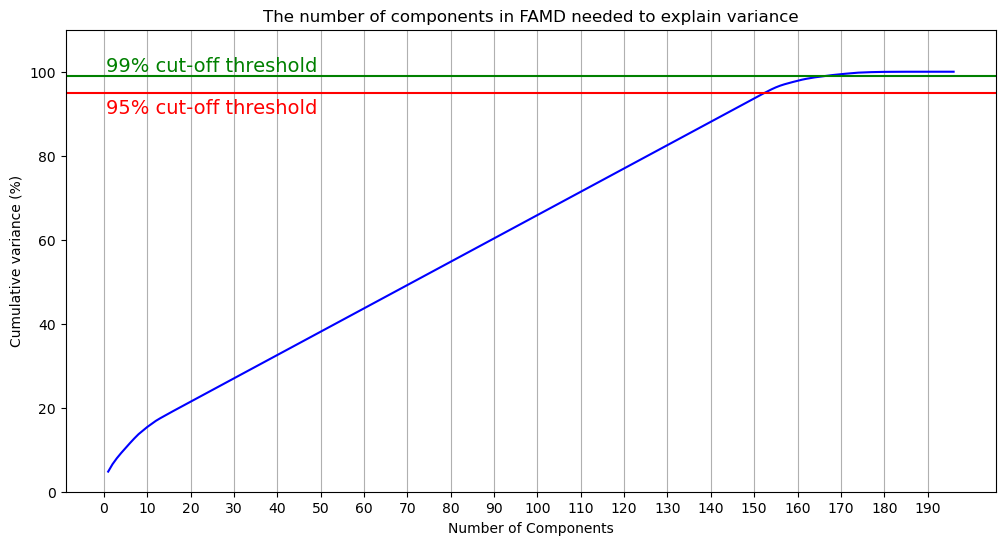

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
xi = np.arange(1, num_components+1, step=1)
y = famd.cumulative_percentage_of_variance_

plt.rcParams["figure.figsize"] = (12,6)

plt.ylim(0.0, 110)
plt.plot(xi, y, linestyle='-', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, num_components+1, step=10))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components in FAMD needed to explain variance')

plt.axhline(y=95, color='r', linestyle='-')
plt.text(0.5, 90, '95% cut-off threshold', color='red', fontsize=14)

plt.axhline(y=99, color='g', linestyle='-')
plt.text(0.5, 100, '99% cut-off threshold', color='green', fontsize=14)

ax.grid(axis='x')
plt.show()

In [7]:
# Generator to generate the first index that is above 95%
gen = (
    i for (i, n) in enumerate(famd.cumulative_percentage_of_variance_)
    if n > 95
)

famd_n_components = next(gen)
print(f"Thus, the number of components required to explain 95% of the inertia is {famd_n_components}")

Thus, the number of components required to explain 95% of the inertia is 152


In [8]:
famd = FAMD(
    n_components=famd_n_components,
    random_state=42,
    engine="sklearn"
)
famd = famd.fit(x_df)
x_df = famd.transform(x_df)

In [9]:
x_df

component,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151
0,-1.335769,-2.309365,-0.152429,0.991074,-0.428719,0.332706,-0.100596,-0.156373,0.434281,0.338866,0.105038,0.094985,-0.408162,0.051741,-0.040463,0.190530,0.009373,0.024715,0.012635,0.007594,0.001877,0.004001,0.003517,-0.000940,0.001377,0.005533,0.002763,0.000762,-0.000047,0.000265,-0.000062,-0.000140,0.000052,1.031810e-07,-1.886405e-11,-3.337825e-11,1.437392e-10,-4.088932e-12,2.289936e-11,-2.958046e-11,-4.908962e-12,-3.511263e-11,-2.127722e-11,-7.567134e-12,1.959801e-11,2.911662e-11,3.203677e-11,-9.208036e-12,-1.190171e-11,1.315293e-11,-1.533841e-11,1.211717e-11,-1.455940e-11,4.087861e-11,7.910721e-12,-5.739605e-12,9.501258e-13,6.864864e-12,-6.428185e-13,2.009377e-11,-2.745129e-11,-1.409059e-11,-4.068615e-12,4.809531e-12,-1.546293e-12,-2.588397e-11,9.745745e-12,-2.138111e-12,1.332888e-11,3.871702e-12,3.501298e-11,1.136660e-11,-2.643254e-11,-3.712744e-13,2.000607e-11,6.226603e-11,3.477617e-11,-7.003028e-12,-8.366145e-12,-9.510083e-12,-1.369337e-11,1.638106e-11,3.606742e-11,3.468314e-11,2.635003e-11,-1.133509e-11,3.301398e-11,-1.183515e-11,1.761048e-11,2.569001e-11,1.902406e-11,1.273867e-11,-3.067942e-12,-9.250603e-12,-2.323110e-11,3.771722e-11,3.914396e-12,7.380478e-12,-3.257809e-12,1.031022e-11,-7.158539e-11,1.866757e-11,3.364311e-11,2.866622e-12,4.661124e-12,2.530218e-11,3.399585e-11,-7.811280e-12,-4.027982e-11,1.994849e-11,3.393896e-11,-4.170549e-11,-1.291140e-13,3.844093e-11,8.484669e-12,4.599626e-12,-1.962508e-12,4.931472e-11,1.457015e-12,-1.237504e-11,-1.961392e-11,1.752136e-11,1.640398e-10,3.350544e-11,1.133816e-10,-7.291435e-10,-4.452716e-09,2.349408e-08,8.309692e-08,-1.090296e-06,0.000002,-0.000067,-0.000008,-0.000013,-0.000336,-0.000142,0.000127,0.001289,0.000905,-0.002276,0.003636,-0.000286,-0.005112,-0.001635,-0.003284,-0.011154,0.015813,0.066660,-0.046194,0.000068,0.120426,-0.043834
1,-1.551698,-2.710129,-0.278598,2.004212,-0.074090,0.310220,-0.073514,-0.452415,1.370564,-0.218700,0.233653,0.057041,-2.414110,-0.253247,0.268431,0.053227,-0.005402,0.008948,0.012434,0.032241,-0.046243,0.042191,0.006872,-0.013355,0.007346,0.007657,0.002666,0.000848,-0.000388,0.000216,-0.000063,-0.000157,0.000043,1.031155e-07,-1.764889e-11,-3.568609e-11,1.449198e-10,-4.413894e-12,2.372719e-11,-2.274025e-11,3.405828e-12,-3.049116e-11,-2.211037e-11,-5.167598e-12,1.673270e-11,3.087892e-11,3.492253e-11,-1.096701e-11,-6.062259e-12,1.054260e-11,-1.623743e-11,4.391536e-12,-1.067162e-11,3.188240e-11,1.524497e-11,-8.247120e-12,9.961324e-12,-3.034377e-12,4.761788e-13,1.424314e-11,-2.682475e-11,-1.356328e-11,1.124759e-12,1.161037e-12,-1.065301e-14,-3.431030e-11,2.549481e-12,7.313270e-12,1.206345e-11,6.633875e-12,3.388481e-11,1.288495e-11,-2.604178e-11,3.928984e-12,2.252312e-11,6.290250e-11,4.267713e-11,2.149671e-12,-5.225254e-12,-5.657913e-15,-8.720932e-12,1.376723e-11,3.287169e-11,2.209175e-11,2.660424e-11,-2.689665e-12,4.329477e-11,-1.142862e-11,1.971598e-11,2.150766e-11,2.378770e-11,2.542240e-11,-1.599671e-11,-1.000992e-11,-1.398191e-11,2.637644e-11,-8.895815e-12,3.054049e-11,-2.900138e-11,1.039149e-11,-6.046937e-11,1.046924e-11,3.249767e-11,5.145577e-12,1.857062e-12,2.743028e-11,3.781852e-11,-4.673481e-15,-4.227548e-11,1.258779e-11,4.434600e-11,-4.061634e-11,8.844989e-13,6.928265e-11,-2.233671e-11,1.811523e-12,4.711265e-12,4.626145e-11,-5.308583e-14,-6.704615e-12,-1.919209e-11,2.372669e-11,1.466637e-10,3.406041e-11,1.230559e-10,-5.563237e-10,-3.471721e-09,1.642907e-08,6.168095e-10,-1.090793e-06,0.000001,-0.000069,-0.000010,-0.000006,-0.000313,-0.

### Binary classification model
Split the dataset into train, test sets with a test set size of 0.2 of total size 

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_df, labels, stratify=labels, test_size=.2, random_state=42)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((206138, 152), (51535, 152), (206138,), (51535,))

We standardize the numerical features to satisfy the assumption that many ML models have on the provided data.

In [11]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test = pd.DataFrame(sc.transform(X_test))

Split the training set further by using 10000 records as validation samples.

In [12]:
X_val = X_train.iloc[-10000:]
y_val = y_train.iloc[-10000:]

X_train = X_train.iloc[:-10000]
y_train = y_train.iloc[:-10000]

print(f"Training dataset:   {(X_train.shape, y_train.shape)}")
print(f"validation dataset: {(X_val.shape, y_val.shape)}")

Training dataset:   ((196138, 152), (196138,))
validation dataset: ((10000, 152), (10000,))


In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [14]:
def create_binary_model():
    model = keras.Sequential(
        [
            layers.Dense(43, activation='relu', input_dim=X_train.shape[1]),
            layers.BatchNormalization(),
            layers.Dropout(rate=0.028454008433744526),
            layers.Dense(25, activation='relu', use_bias=True),
            layers.Dense(90, activation='relu', use_bias=True),
            layers.Dense(1, activation='sigmoid', use_bias=True)
        ]
    )
    model.compile('adam', loss='binary_crossentropy', metrics='accuracy')
    return model

model = create_binary_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 43)                6579      
                                                                 
 batch_normalization (BatchN  (None, 43)               172       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 43)                0         
                                                                 
 dense_1 (Dense)             (None, 25)                1100      
                                                                 
 dense_2 (Dense)             (None, 90)                2340      
                                                                 
 dense_3 (Dense)             (None, 1)                 91        
                                                        

In [15]:
import os

checkpoint_path = "../models/model_dnn_b_famd.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

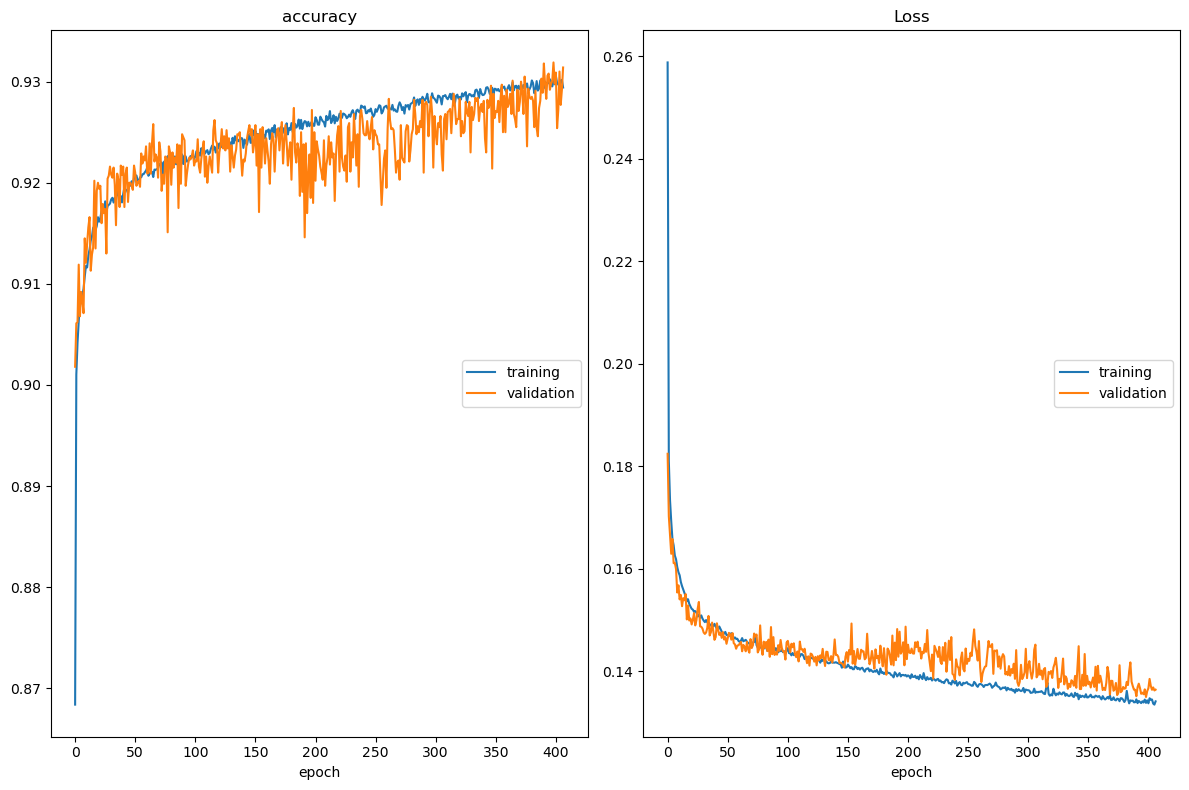

accuracy
	training         	 (min:    0.868, max:    0.931, cur:    0.929)
	validation       	 (min:    0.902, max:    0.932, cur:    0.931)
Loss
	training         	 (min:    0.133, max:    0.259, cur:    0.134)
	validation       	 (min:    0.135, max:    0.182, cur:    0.136)
364/364 - 1s - loss: 0.1341 - accuracy: 0.9294 - val_loss: 0.1364 - val_accuracy: 0.9314 - 1s/epoch - 4ms/step


In [16]:
EPOCHS = 407
BATCH_SIZE = 540

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=BATCH_SIZE)

history = model.fit(X_train,
                    y_train, 
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    verbose=2,
                    callbacks=[PlotLossesKeras(), cp_callback])

In [17]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape((y_pred.shape[0],))

1611/1611 [==============================] - 2s 1ms/step


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred.round())
cm = np.around(cm / cm.astype('float').sum(axis=1, keepdims=True), decimals=3)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(list(labels.unique())))

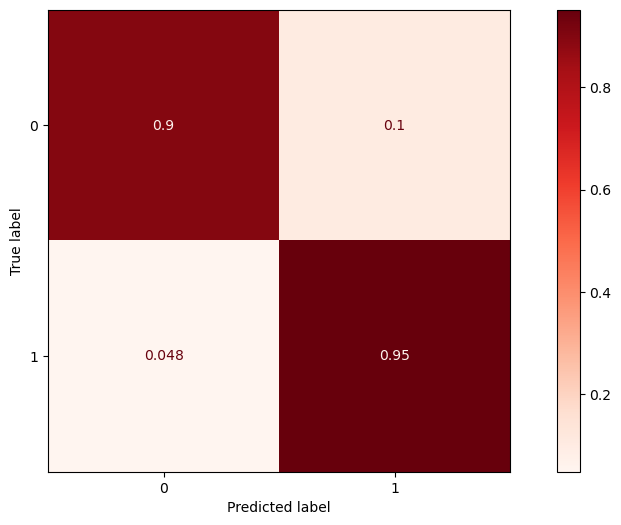

In [19]:
import matplotlib.pyplot as plt

disp.plot(cmap=plt.cm.Reds, xticks_rotation=0)

In [20]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, precision_score, f1_score

ys = y_test
ys_pred = y_pred.round()

print(f"Accuracy score:                   {accuracy_score(ys, ys_pred)}")
print(f"Matthews correlation coefficient: {matthews_corrcoef(ys, ys_pred)}")
print(f"recall score (weighted):          {recall_score(ys, ys_pred)}")
print(f"precision score (weighted):       {precision_score(ys, ys_pred)}")
print(f"f1 score (weighted):              {f1_score(ys, ys_pred)}")


Accuracy score:                   0.9319297564761813
Matthews correlation coefficient: 0.8519312682021253
recall score (weighted):          0.9520267192955822
precision score (weighted):       0.9420725295195745
f1 score (weighted):              0.9470234679392311


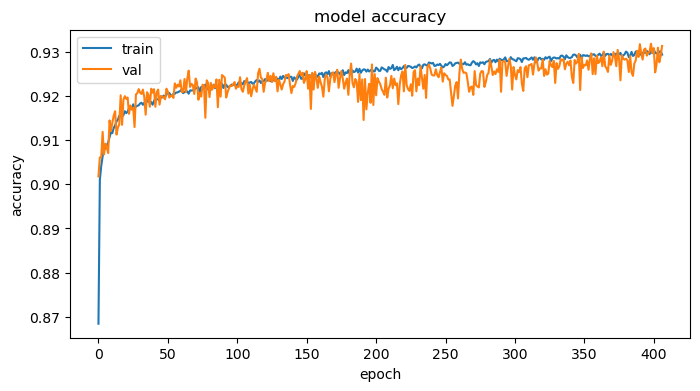

In [21]:
plt.rcParams["figure.figsize"] = (8,4)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

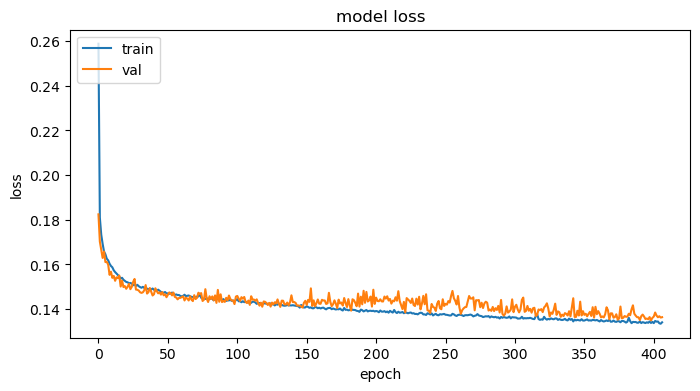

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Multi-class model

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_df, pd.get_dummies(mc_labels), stratify=pd.get_dummies(mc_labels), test_size=.2, random_state=42)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((206138, 152), (51535, 152), (206138, 10), (51535, 10))

In [24]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test = pd.DataFrame(sc.transform(X_test))

In [25]:
X_val = X_train.iloc[-10000:]
y_val = y_train.iloc[-10000:]

X_train = X_train.iloc[:-10000]
y_train = y_train.iloc[:-10000]

print(f"Training dataset:   {(X_train.shape, y_train.shape)}")
print(f"validation dataset: {(X_val.shape, y_val.shape)}")

Training dataset:   ((196138, 152), (196138, 10))
validation dataset: ((10000, 152), (10000, 10))


In [26]:
def create_multiclass_model():
    model = keras.Sequential(
        [
            layers.Dense(27, activation='relu', input_dim=X_train.shape[1]),
            layers.BatchNormalization(),
            layers.Dense(173, activation='relu', use_bias=True),
            layers.Dropout(rate=0.2942475563821516),
            layers.Dense(151, activation='relu', use_bias=True),
            layers.Dense(21, activation='relu', use_bias=True),
            layers.Dense(10, activation='softmax', use_bias=True)
        ]
    )
    model.compile('adam', loss='categorical_crossentropy', metrics='accuracy')
    return model

model = create_multiclass_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 27)                4131      
                                                                 
 batch_normalization_1 (Batc  (None, 27)               108       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 173)               4844      
                                                                 
 dropout_1 (Dropout)         (None, 173)               0         
                                                                 
 dense_6 (Dense)             (None, 151)               26274     
                                                                 
 dense_7 (Dense)             (None, 21)                3192      
                                                      

In [27]:
import os

checkpoint_path = "../models/model_dnn_mc_famd.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

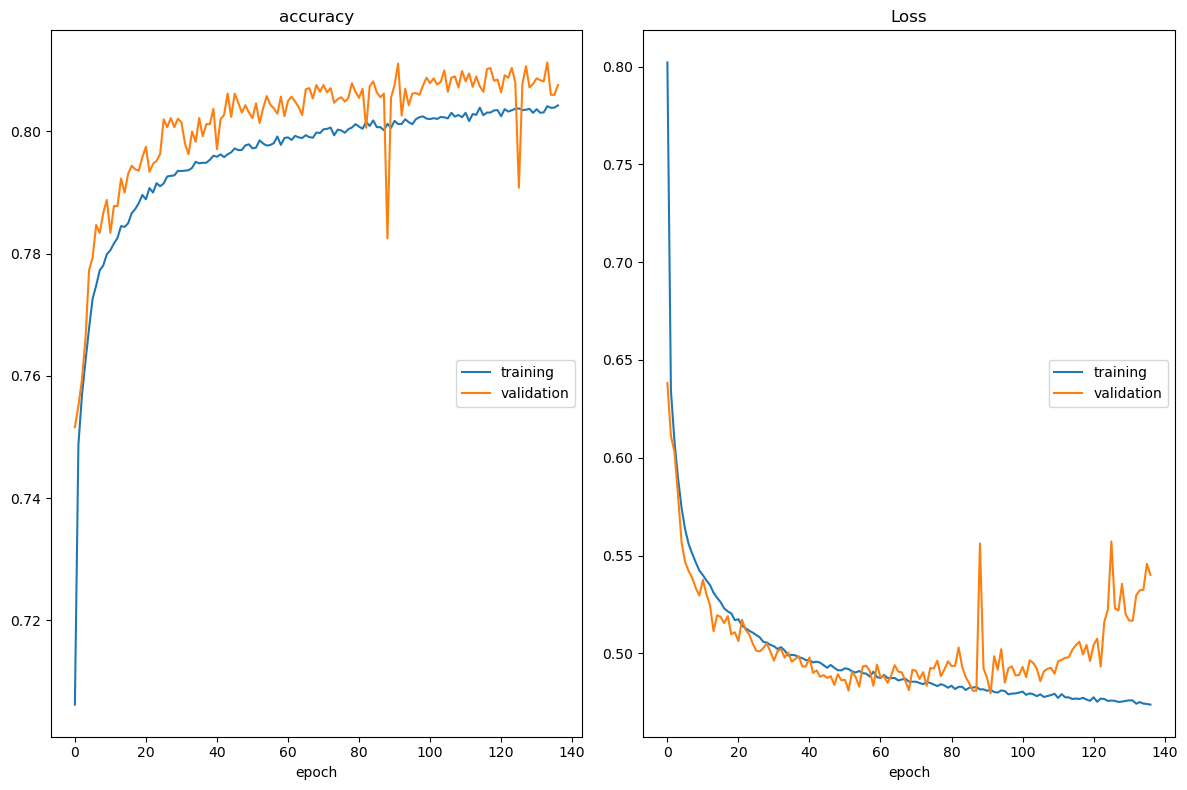

accuracy
	training         	 (min:    0.706, max:    0.804, cur:    0.804)
	validation       	 (min:    0.752, max:    0.811, cur:    0.808)
Loss
	training         	 (min:    0.474, max:    0.802, cur:    0.474)
	validation       	 (min:    0.480, max:    0.638, cur:    0.540)
663/663 - 4s - loss: 0.4738 - accuracy: 0.8043 - val_loss: 0.5401 - val_accuracy: 0.8076 - 4s/epoch - 6ms/step


In [28]:
EPOCHS = 137
BATCH_SIZE = 296

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=BATCH_SIZE)

history = model.fit(X_train,
                    y_train, 
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    verbose=2,
                    callbacks=[PlotLossesKeras(), cp_callback])

In [29]:
y_pred = model.predict(X_test)

1611/1611 [==============================] - 3s 2ms/step


In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test.to_numpy().argmax(axis=1), y_pred.argmax(axis=1))
cm = np.around(cm / cm.astype('float').sum(axis=1, keepdims=True), decimals=3)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(list(mc_labels.unique())))

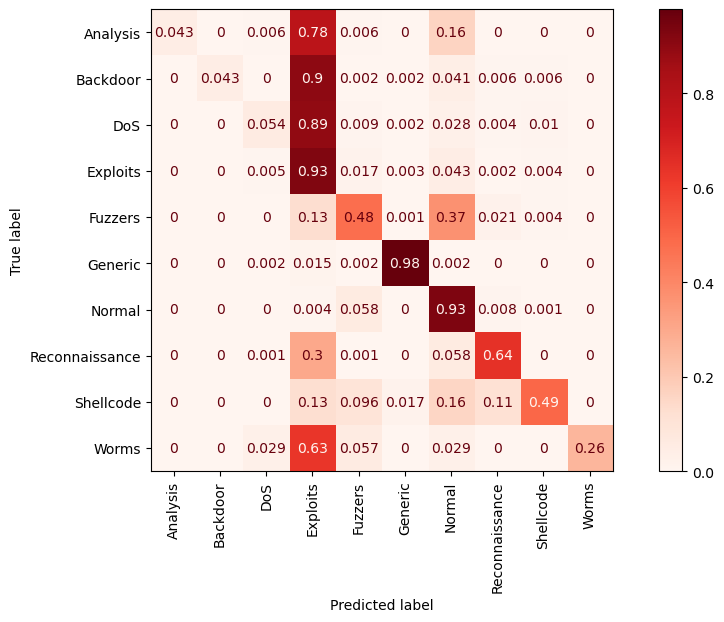

In [31]:
plt.rcParams["figure.figsize"] = (12,6)
disp.plot(cmap=plt.cm.Reds, xticks_rotation=90)

In [32]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, precision_score, f1_score, auc

ys = y_test.to_numpy().argmax(axis=1)
ys_pred = y_pred.argmax(axis=1)

print(f"Accuracy score:                   {accuracy_score(ys, ys_pred)}")
print(f"Matthews correlation coefficient: {matthews_corrcoef(ys, ys_pred)}")
print(f"recall score (weighted):          {recall_score(ys, ys_pred, average='weighted')}")
print(f"precision score (weighted):       {precision_score(ys, ys_pred, average='weighted')}")
print(f"f1 score (weighted):              {f1_score(ys, ys_pred, average='weighted')}")

Accuracy score:                   0.8059377122344038
Matthews correlation coefficient: 0.7499863529123239
recall score (weighted):          0.8059377122344038
precision score (weighted):       0.8165802810285135
f1 score (weighted):              0.7777165478547141
